## 1. Introduction

The problem statement of the financial sentiment analysis dataset is to predict the sentiment of financial articles or social media posts related to financial markets or specific financial instruments, e.g.: stocks, currencies, etc.

The goal of financial sentiment analysis is to extract insights from the large volumes of unstructured data generated by financial news and social media, and to provide an early warning system for investors and traders to make informed decisions.
* Inputs: The dataset used for this analysis is collected from Kaggle, intended for advancing financial sentiment analysis research (https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis/data). The data are included in one CSV file, with 5322 unique sentences, related to financial statements, and their sentiment labels (positive/negative/neutral).

* Outputs: Predicted sentiment outcomes based on words used of each financial statement.

* Method: Text classification, also known as text categorization or text tagging, is a fundamental task in Natural Language Processing (NLP). It involves automatically assigning text data into predefined categories or classes, which can be applied to solve several kinds of problem, such as Sentiment analysis, Topic labeling, Spam Filtering, Intent Detection, Document Classification, etc.

* Processing Requirements:
    * Data Importing: Import CSV data file into Python.
    * Statistics of Sample Data: Explore distributions, key features, and statistics of data.
    * Data Preprocessing: Clean data by removing duplicated/NA values and transform to predictable data by dropping unmeaningful words and combining words into a string.
    * Model Creating, Training, and Evaluation:
        * Split data into Training set and Testing set;
        * Train models to predict sentiment outcomes;
        * Evaluate the accuracy of model using Testing set by comparing predicted sentiment outcomes with given outcomes in the dataset.


## 2. Data Preprocessing

### 2.1. Import Library

In [2]:
import numpy as np
import pandas as pd
import seaborn  as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import string
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv('data.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


### 2.2. Statistics of Sample Data

In [4]:
df.shape

(5842, 2)

In [5]:
sentiment_counts = df['Sentiment'].value_counts

In [6]:
df.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


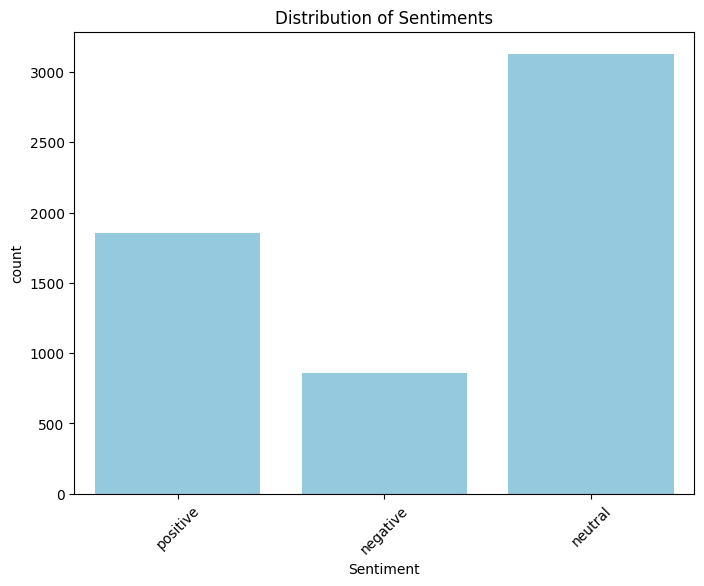

In [6]:
plt.figure(figsize=(8,6))
sns.countplot(x='Sentiment', data=df, color='skyblue')
plt.title('Distribution of Sentiments')
plt.xticks(rotation=45)
plt.show()

(-1.1113356657608995,
 1.1526276908251913,
 -1.1058100748512958,
 1.1058915570155745)

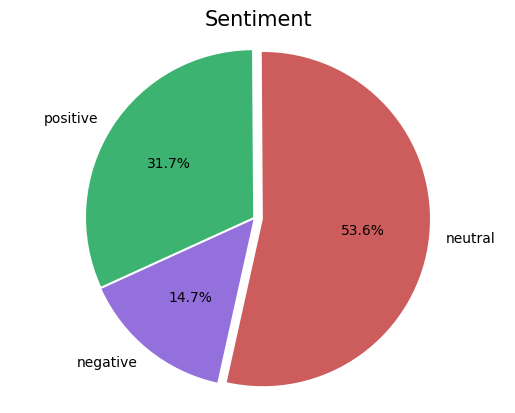

In [17]:
plt.pie(df['Sentiment'].value_counts().values, labels=df['Sentiment'].value_counts().index,autopct='%1.1f%%',startangle=-102.5,colors=('indianred','mediumseagreen','mediumpurple'),explode=(0.05,0.01,0.01))
plt.title('Sentiment', fontsize=15)
plt.axis("equal")

### 2.3. Data Preprocessing

In [7]:
#Check missing values
df.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

In [8]:
#Check duplicate values
df.duplicated().sum()

6

In [9]:
#Drop duplicate values
df.drop_duplicates(inplace=True)
#Remove missing values
df.dropna(inplace=True)
#Import common English stopwords
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    #Tokenise the text
    tokens = word_tokenize(text)
    #Convert to lowercase
    tokens = [word.lower() for word in tokens]
    #Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    #Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    #Join tokens back into string
    return " ".join(tokens)
#Apply preprocessing to the 'Sentence' column
df['Processed_Text'] = df['Sentence'].apply(preprocess_text)
#Drop the original 'Sentences' column
df.drop(columns=['Sentence'], inplace=True)
#Save cleaned data to a new CSV file
df.to_csv('cleaned_dataset.csv', index=False)

In [10]:
df.head()

,Sentiment,Processed_Text
0,positive,geosolutions technology leverage benefon 's gp...
1,negative,esi lows 1.50 2.50 bk real possibility
2,positive,last quarter 2010 componenta 's net sales doub...
3,neutral,according finnish-russian chamber commerce maj...
4,neutral,swedish buyout firm sold remaining 22.4 percen...


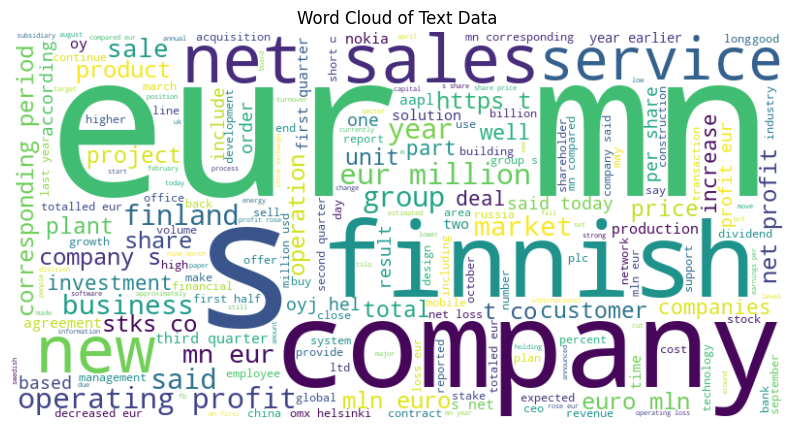

In [11]:
#Combine all sentences into a single string
all_text = ' '.join(df['Processed_Text'])
#Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
#Plot the WordCloud
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Text Data')
plt.axis('off')
plt.show()

## 3. Model Creating, Training, and Evaluating

We use two models for this sentiment analysis problem:
* Multinomial Naive Bayes
* Random Forest Classifier

Metrics used for evaluating models: From Classification Report
* Precision value for each class (positive, negative, neutral): A higher precision indicates a model predicts a class more accurately (less false positives)
* Recall value for each class (positive, negative, neutral): A higher recall signifies a model captures more of the actual positive cases (less false negative)
* F1-Score: A higher F1-score indicates a good balance between the two Precision value and Recall value
* Overall Accuracy: A higher accuracy suggests better overall performance

Stop condition when training models:
* Naive Bayes training essentially finishes once it calculates the probabilities of words belonging to each sentiment class based on the training data.
* Random Forest oftern uses pre-defined stopping criteria within the training process to prevent overfitting:
    * Maximum Number of Trees: A pre-defined number of decision trees are built before stopping. This parameter controls the model's complexity.
    * Minimum Decrease in Impurity: Training stops when the decrease in the impurity measure between subsequent trees falls below a set threshold. This prevents the model from learning irrelevant details from the training data.
    * Number of Samples per Leaf Node: Training stops when a minimum number of samples is reached in each leaf node of the trees. This avoids overfitting by preventing the model from specializing on too few data points.

In [12]:
#Convert textual data into numerical features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Processed_Text'])
Y = df['Sentiment']

In [13]:
# Split into Training and Testing datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### 3.1. Naive Bayes Classifier Model

In Naive Bayes for sentiment analysis, the features are typically the individual words themselves. Each word is treated as a binary feature, indicating its presence or absence in a document.

In [14]:
# Import model
from sklearn.naive_bayes import MultinomialNB

In [15]:
#Build and train the Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train, Y_train)

MultinomialNB()

In [16]:
#Evaluate the NB model
Y_pred_NB = NB_model.predict(X_test)
print(classification_report(Y_test, Y_pred_NB))

              precision    recall  f1-score   support

    negative       0.57      0.03      0.05       159
     neutral       0.69      0.96      0.80       666
    positive       0.66      0.45      0.54       343

    accuracy                           0.68      1168
   macro avg       0.64      0.48      0.46      1168
weighted avg       0.66      0.68      0.62      1168



The printed result shows that the accuracy of Naive Bayes model is 68%, which means of the total number of instances, the number of correctly predicted instances is 68%.

### 3.2. Random Forest Classifier Model

Random Forest uses a more flexible approach to features compared to Naive Bayes. Here are some common feature engineering techniques:
* Bag-of-Words (BoW): Represents documents as a vector where each element indicates the frequency of a word in the document.
* TF-IDF (Term Frequency-Inverse Document Frequency): Similar to BoW, but weights words based on their importance in the document and rarity across the entire dataset.
* N-grams: Sequences of words (e.g., bigrams, trigrams) can be used to capture word order and context, which can be helpful for sentiment analysis.

In [17]:
#Import model
from sklearn.ensemble import RandomForestClassifier

In [19]:
#Build and train the Random Forest model
RF_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
RF_model.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [20]:
#Evaluate the RF model
Y_pred_RF = RF_model.predict(X_test)
print(classification_report(Y_test, Y_pred_RF))

              precision    recall  f1-score   support

    negative       0.13      0.10      0.11       159
     neutral       0.70      0.81      0.75       666
    positive       0.75      0.60      0.67       343

    accuracy                           0.65      1168
   macro avg       0.53      0.50      0.51      1168
weighted avg       0.64      0.65      0.64      1168



The printed result shows that the accuracy of Random Forest model is 65%, which means the number of correctly predicted instances is 65% of the total number of instances.

### 3.3 Comparison of Naive Bayes model and Random Forest model

Let the result of the Naive Bayes model and Random Forest model be Result A and Result B, respectively.

#### a. Metric-by-Metric Comparison

* Precision: Compare the precision values for each class (negative, neutral, positive), between Result A and Result B. A higher precision indicates a model predicts a class more accurately (less false positives). In this case, the Result A higher precision for 'negative' but lower precision for 'neutral' and 'positive' compared to Result B.
* Recall: Compare the recall values for each class. A higher recall signifies a model captures more of the actual positive cases (less false negative). Here, Result A has significantly lower recall for 'negative' but much higher recall for 'neutral' compared to Result B. The recall for 'postive' is also lower in Result A.
* F1-Score: This metric combines precision and recall. A higher F1-score indicates a good balance between the two. Analyse the F1-score for each class to see which model performs better for that specific class. In this case, Result B has a higher F1-score for 'positive', while Result A has a higher F1-score for 'neutral'.

#### b. Macro versus Weighted Average

* Macro Average: This treats all classes equally. Compare the macro-averaged precision, recall, and F1-score between the two results. A higher macro average indicates better overall performance across all classes, regardless of their imbalance. Here, Result A has slightly higher macro averages for precision and F1-score.
* Weighted Average: This considers the class imbalance by weighting the metrics based on the number of instances in each class. Analyse the weighed-averaged metrics to see now the models perform considering the class distribution. In this case, Result A has higher weighted average precision and F1-score.

#### c. Accuracy

Compare the overall accuracy (percentage of correctly predicted instances) between Result A and Result B. A higher accuracy suggests better overall performance. Here, Result A has a slightly higher accuracy.

#### d. Overall conclusion

Based on the comparison, it's difficult to definitively say which model is better.

* Result A: Has higher precision and recall for 'neutral' class and slightly better overall macro and weighted averages, but performs worse for 'negative' class prediction (very low recall) and has lower F1-score for the 'positive' class.
* Result B: Performs better for 'positive' class prediction (higher F1-score) but has lower overall precision and recall compared to Result B.

However, if the comparison of superiority and inferiority of accuracy between the two model is required, the Naive Bayes seems to have a slightly better result than the Random Forest model due to its higher overall accuracy.

## 5. Conclusion

### 5.1. Advantages and Disadvatages of the Approach

#### a. Naive Bayes model

* Advantages:
    * Simple: The Naive Bayes model is relatively simple algorithm that is easy to understand and implement with an acceptably high accuracy.
    * Interpretability: Understanding why a sentiment is predicted can be valuable in financial analysis. Naive Bayes allows you to analyze word probabilities for interpretability.
    * Efficiency: Training Naive Bayes is faster, especially with smaller datasets that are common in financial analysis due to the cost of labeled data.

* Disadvantages:
    * Overlooking Nuance: Financial language can be nuanced, with subtle differences in phrasing conveying significant sentiment changes. Naive Bayes' independence assumption might miss these subtleties.
    * Negation Handling: Financial texts often use negation to express opposite sentiment. Naive Bayes might struggle to handle negation effectively.
    * Limited Accuracy: Compared to Random Forest, Naive Bayes might achieve lower accuracy on complex financial sentiment analysis tasks.

### b. Random Forest Model

* Advantages:
    * High Accuracy: Random Forest can achieve higher accuracy on complex tasks, potentially leading to better insights in financial sentiment analysis.
    * Handles Feature Dependence: Random Forest can capture the relationships between words, which is crucial for understanding sentiment in financial texts.
    * Robustness: Less sensitive to noise and outliers in financial data compared to Naive Bayes.

* Disadvantages:
    * Complexity: Training and interpreting Random Forest can be more complicated compared to Naive Bayes.
    * Overfitting Potential: Financial data can be imbalanced with fewer negative sentiment examples. Random Forest requires careful tuning to avoid overfitting.
    * Computational Cost: Training Random Forest on large financial datasets can be computationally expensive.

### 5.2. Applicability of Research Results in the future

Both Naive Bayes and Random Forest have their strengths that make them suitable for different scenarios in sentiment analysis.

#### a. Naive Bayes model

Naive Bayes is suitable and performs effectively for small amount of labeled training data and small datasets rather than those complex, noisy, and large datasets. Therefore, Naive Bayes can be used for other sentiment analysis, such as:
* Analysing short customer review where sentiment is fairly straightforward (positive/negative).
* Filtering social media comments for basic sentiment classification (positive/negative/neutral).
* Performing sentiment analysis on a limited dataset of news articles.

#### b. Random Forest model

Random Forest can effectively learn from large and complex datasets, potentially achieving higher accuracy than Naive Bayes with better handling of noisy data and less overfitting. For further application, there are some suggestions of cases using Random Forest for sentiment analysis:
* Analyzing customer reviews with complex language, including sarcasm or irony.
* Analyzing social media comments to detect hate speech or offensive language.
* Performing sentiment analysis on a large dataset of product descriptions.